In [1]:
import numpy as np
import matplotlib.pyplot as plt

% matplotlib inline

In [2]:
Xy_numu = np.load("Xy_numu_sel5.npz")
Xy_nue = np.load("Xy_nue.sel5.npz")

X_numu = Xy_numu["x"]
X_nue = Xy_nue["x"]

#y_numu = Xy_numu["y"]
#y_nue = Xy_nue["y"]


In [3]:
y_numu = np.load("numu_sel5_dir_z.npz")
y_nue = np.load("nue_sel5_dir_z.npz")

In [4]:
y_numu=y_numu["z"]
y_nue=y_nue["z"]

In [ ]:
updown_numu = np.load("updown_numu_sel5.npz")
updown_nue = np.load("updown_nue_sel5.npz")

upgoing_numu_indx = updown_numu["up"]
downgoing_numu_indx = updown_numu[ "down"]

upgoing_nue_indx = updown_nue["up"]
downgoing_nue_indx = updown_nue[ "down"]

In [3]:
X_numu_up = X_numu[upgoing_numu_indx]
y_numu_up = y_numu[upgoing_numu_indx]

X_numu_down = X_numu[downgoing_numu_indx]
y_numu_down = y_numu[downgoing_numu_indx]

X_nue_up = X_nue[upgoing_nue_indx]
y_nue_up = y_nue[upgoing_nue_indx]

X_nue_down = X_nue[downgoing_nue_indx]
y_nue_down = y_nue[downgoing_nue_indx]

In [4]:
y_nue_up = y_nue_up+1
y_numu_down = 0*y_numu_down

In [5]:
X_up = np.vstack((X_numu_up, X_nue_up))

y_up = np.hstack((y_numu_up, y_nue_up))

X_down = np.vstack((X_numu_down, X_nue_down))

y_down = np.hstack((y_numu_down, y_nue_down))

X = np.vstack((X_up,X_down))

y = np.hstack((y_up,y_down))

In [6]:
np.all(y_up==1)

True

In [7]:
np.all(y_down==0)

True

In [5]:
X = np.vstack((X_numu, X_nue))
y = np.hstack((y_numu,y_nue))

In [6]:
X.shape, y.shape

((2565, 75, 16, 15, 18), (2565,))

In [7]:
import keras

Using TensorFlow backend.


In [8]:
from tensorflow.python.client import device_lib
def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']


In [9]:
get_available_gpus()

[u'/gpu:0', u'/gpu:1']

In [10]:
keras.backend.image_data_format()

'channels_first'

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [12]:
indices = np.arange(X.shape[0])
X_train, X_test, y_train, y_test, indx_train, indx_test = train_test_split(X, y, indices, test_size=0.20, 
                                                                           random_state=42)

In [13]:
from history_plot import history_plot, history_plot_cv

In [75]:
from keras.layers import Input
from keras.layers import concatenate, add
from keras.layers.convolutional import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers.core import Flatten, Dense

from keras.models import Model
from keras.losses import categorical_crossentropy
from keras.optimizers import Adadelta

def vgg_separate_channels(num_classes, optimizer, include_dense=False):
    """VGG inspired Convolutional Networks with multiple inputs
    
    Parameters
    ----------
    num_classes : int
        Number of classes to predict
            
    optimizer : keras.optimizers.Optimizer
        Instance of Keras optimizer to attach to the resulting network
        
    include_dense : bool (default False)
        Flag indicating wether to include a Dense Layer at the top 
        of each separate vgg-like sub-network.
    """
    
    def _conv_block(input_layer, include_dense=False):
        """VGG-inspired Convolutional Blocks"""
        
        prefix = input_layer.name.split('_')[0]

        # Block 1
        x = Conv2D(32, kernel_size=(3, 3), activation='relu', 
                   padding='same', name='{}_block1_conv1'.format(prefix))(input_layer)
        
        x = Conv2D(32, kernel_size=(3, 3), activation='relu', 
                   padding='same', name='{}_block1_conv2'.format(prefix))(x)
        
        x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), 
                         padding='same', name='{}_block1_pool'.format(prefix))(x)

        # Block 2
        x = Conv2D(64, kernel_size=(3, 3), activation='relu', 
                   padding='same', name='{}_block2_conv1'.format(prefix))(x)
        
        x = Conv2D(64, kernel_size=(3, 3), activation='relu', 
                   padding='same', name='{}_block2_conv2'.format(prefix))(x)
        
        x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), 
                         padding='same', name='{}_block2_pool'.format(prefix))(x)

        # Block 3
        x = Conv2D(128, kernel_size=(3, 3), activation='relu', 
                   padding='same', name='{}_block3_conv2'.format(prefix))(x)
        
        x = AveragePooling2D(pool_size=(2, 2), strides=(2, 2), 
                             padding='same', name='{}_block3_pool'.format(prefix))(x)
        x = Flatten()(x)
        if include_dense:
            x = Dense(512)(x)
        return x


    ZT_SHAPE = (1, 75, 18)
    XY_SHAPE = (1, 16, 15)
    
    zt_layer = Input(shape=ZT_SHAPE, name='zt_input')
    xy_layer = Input(shape=XY_SHAPE, name='xy_input')
    
    zt_branch = _conv_block(zt_layer, include_dense)
    xy_branch = _conv_block(xy_layer, include_dense)
    
    # top
    if include_dense:
        x = add([zt_branch, xy_branch], name='merge_add')
    else:
        x = concatenate([zt_branch, xy_branch], name='merge_concat')
        
    x = Dense(256,activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=[zt_layer, xy_layer], outputs=predictions, name='vgglike')
    model.compile(loss=categorical_crossentropy, optimizer=optimizer, metrics=['accuracy'])
    return model

In [16]:
ZT_train = np.sum(X_train, axis=(2, 3))
XY_train = np.sum(X_train, axis=(1, 4))

ZT_train = ZT_train[:, np.newaxis, ...]
XY_train = XY_train[:, np.newaxis, ...]

In [17]:
ZT_train.shape, XY_train.shape

((1480, 1, 75, 18), (1480, 1, 16, 15))

In [18]:
ZT_test = np.sum(X_test, axis=(2, 3))
XY_test = np.sum(X_test, axis=(1, 4))

ZT_test = ZT_test[:, np.newaxis, ...]
XY_test = XY_test[:, np.newaxis, ...]

#### CrossValidation Score

In [32]:
from keras.backend import clear_session

def cross_validation_score(K, N, X_train, y_train, f_model, f_args, fit_args):
    """"""
    iteration_tr_score = list()
    iteration_val_score = list()
    histories_cnn = list()
    
    def iteration_metrics(scores):
        mean_score = np.mean(scores)
        min_score = np.min(scores)
        max_score = np.max(scores)
        return mean_score, min_score, max_score
    
    for iteration in range(N):
        tr_accuracy_scores = list()
        val_accuracy_scores=list()
        
        skf = StratifiedKFold(n_splits=K, random_state=iteration)
        
        for i, (train_index, validation_index) in enumerate(skf.split(X_train, y_train)):
            print("[Iteration %d/%d] Test nr.: %d/%d" % (iteration+1, N, i+1, K))
            
            Xtrain, Xvalidation = X_train[train_index], X_train[validation_index]
            ytrain, yvalidation = y_train[train_index], y_train[validation_index]

            model = f_model(**f_args)
            
            if iteration == 0 and i == 0:
                model.summary()
            
            Ytrain = to_categorical(ytrain)
            Yvalidation = to_categorical(yvalidation)
            history = model.fit(Xtrain, Ytrain, validation_data = (Xvalidation, Yvalidation), 
                                shuffle=False, **fit_args) 
                        
            histories_cnn.append(history)
            training_acc = history.history['acc'][-1]
            validation_acc = history.history['val_acc'][-1]
            
            print("\nTraining acc: %f, Validation acc: %f\n" %(training_acc,validation_acc))
            tr_accuracy_scores.append(training_acc)
            val_accuracy_scores.append(validation_acc)
            
        iteration_tr_score.append(iteration_metrics(tr_accuracy_scores))
        iteration_val_score.append(iteration_metrics(val_accuracy_scores))
        
    clear_session()
        
    print("Training metrics: ")
    print("ITER \t MEAN \t MIN \t MAX")
    for it, metric in enumerate(iteration_tr_score):
        print("{0:d} \t {1:.3f} \t {2:.3f} \t {3:.3f}".format(it+1, *metric))
    
    print("Validation metrics: ")
    print("ITER \t MEAN \t MIN \t MAX")
    for it, metric in enumerate(iteration_val_score):
        print("{0:d} \t {1:.3f} \t {2:.3f} \t {3:.3f}".format(it+1, *metric))

    return histories_cnn

In [70]:
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)

In [31]:
fargs = {'num_classes': 2, 'optimizer': Adadelta()}
vgg_sep_model = vgg_separate_channels(**fargs)

In [32]:
vgg_sep_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
zt_input (InputLayer)            (None, 1, 75, 18)     0                                            
____________________________________________________________________________________________________
xy_input (InputLayer)            (None, 1, 16, 15)     0                                            
____________________________________________________________________________________________________
zt_block1_conv1 (Conv2D)         (None, 32, 75, 18)    320         zt_input[0][0]                   
____________________________________________________________________________________________________
xy_block1_conv1 (Conv2D)         (None, 32, 16, 15)    320         xy_input[0][0]                   
___________________________________________________________________________________________

In [76]:
from keras.utils import plot_model
plot_model(vgg_sep_model, to_file='vgg_sep_model.png', show_shapes=True)

Fontconfig warning: ignoring UTF-8: not a valid region tag



In [35]:
fitargs = {'batch_size': 64, 'epochs': 30, 'verbose': 1}
history_vgg_sep = vgg_sep_model.fit([ZT_train, XY_train], to_categorical(y_train), **fitargs)

Epoch 1/30
1480/1480 [==============================] - 5s - loss: 0.5288 - acc: 0.7291     
Epoch 2/30
1480/1480 [==============================] - 5s - loss: 0.4537 - acc: 0.8108     
Epoch 3/30
1480/1480 [==============================] - 5s - loss: 0.3853 - acc: 0.8466     
Epoch 4/30
1480/1480 [==============================] - 5s - loss: 0.3089 - acc: 0.8628     
Epoch 5/30
1480/1480 [==============================] - 5s - loss: 0.2443 - acc: 0.9007     
Epoch 6/30
1480/1480 [==============================] - 5s - loss: 0.2036 - acc: 0.9095     
Epoch 7/30
1480/1480 [==============================] - 5s - loss: 0.1447 - acc: 0.9392     
Epoch 8/30
1480/1480 [==============================] - 5s - loss: 0.2029 - acc: 0.9182     
Epoch 9/30
1480/1480 [==============================] - 5s - loss: 0.1482 - acc: 0.9399     
Epoch 10/30
1480/1480 [==============================] - 5s - loss: 0.1215 - acc: 0.9473     
Epoch 11/30
1480/1480 [==============================] - 5s - loss: 0

In [36]:
print("Use model to make prediction on test data")
predictions = vgg_sep_model.predict([ZT_test,XY_test])
cls_predictions = np.argmax(predictions, axis=1)

from sklearn.metrics import accuracy_score
score = accuracy_score(y_test, cls_predictions)
print("Accuracy score: ", score)

Use model to make prediction on test data
('Accuracy score: ', 0.92452830188679247)


---

### VGG-separate with Dense & ADD

In [38]:
fargs = {'num_classes': 2, 'optimizer': Adadelta(), 'include_dense':True}
vgg_sep_model = vgg_separate_channels(**fargs)

In [39]:
fitargs = {'batch_size': 64, 'epochs': 30, 'verbose': 1}
history_vgg_sep = vgg_sep_model.fit([ZT_train, XY_train], to_categorical(y_train), **fitargs)

Epoch 1/30
1480/1480 [==============================] - 5s - loss: 0.6598 - acc: 0.5993     
Epoch 2/30
1480/1480 [==============================] - 5s - loss: 0.5487 - acc: 0.7372     
Epoch 3/30
1480/1480 [==============================] - 5s - loss: 0.4542 - acc: 0.7912     
Epoch 4/30
1480/1480 [==============================] - 5s - loss: 0.3510 - acc: 0.8493     
Epoch 5/30
1480/1480 [==============================] - 5s - loss: 0.2712 - acc: 0.8824     
Epoch 6/30
1480/1480 [==============================] - 5s - loss: 0.2282 - acc: 0.8959     
Epoch 7/30
1480/1480 [==============================] - 5s - loss: 0.1924 - acc: 0.9209     
Epoch 8/30
1480/1480 [==============================] - 5s - loss: 0.1565 - acc: 0.9324     
Epoch 9/30
1480/1480 [==============================] - 5s - loss: 0.1447 - acc: 0.9419     
Epoch 10/30
1480/1480 [==============================] - 5s - loss: 0.1554 - acc: 0.9338     
Epoch 11/30
1480/1480 [==============================] - 5s - loss: 0

In [40]:
print("Use model to make prediction on test data")
predictions = vgg_sep_model.predict([ZT_test,XY_test])
cls_predictions = np.argmax(predictions, axis=1)

from sklearn.metrics import accuracy_score
score = accuracy_score(y_test, cls_predictions)
print("Accuracy score: ", score)

Use model to make prediction on test data
('Accuracy score: ', 0.90835579514824794)


#### VGG-like with zt channel only

In [39]:
from keras.layers import Input
from keras.layers import concatenate, add
from keras.layers.convolutional import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers.core import Flatten, Dense

from keras.models import Model
from keras.losses import categorical_crossentropy
from keras.optimizers import Adadelta

def vgg_like_zt(num_classes, optimizer, include_dense=False):
    """VGG inspired Convolutional Networks with multiple inputs
    
    Parameters
    ----------
    num_classes : int
        Number of classes to predict
            
    optimizer : keras.optimizers.Optimizer
        Instance of Keras optimizer to attach to the resulting network
        
    include_dense : bool (default False)
        Flag indicating wether to include a Dense Layer at the top 
        of each separate vgg-like sub-network.
    """
    
    def _conv_block(input_layer, include_dense=False):
        """VGG-inspired Convolutional Blocks"""
        
        prefix = input_layer.name.split('_')[0]

        # Block 1
        x = Conv2D(32, kernel_size=(3, 3), activation='relu', 
                   padding='same', name='{}_block1_conv1'.format(prefix))(input_layer)
        
        x = Conv2D(32, kernel_size=(3, 3), activation='relu', 
                   padding='same', name='{}_block1_conv2'.format(prefix))(x)
        
        x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), 
                         padding='same', name='{}_block1_pool'.format(prefix))(x)

        # Block 2
        x = Conv2D(64, kernel_size=(3, 3), activation='relu', 
                   padding='same', name='{}_block2_conv1'.format(prefix))(x)
        
        x = Conv2D(64, kernel_size=(3, 3), activation='relu', 
                   padding='same', name='{}_block2_conv2'.format(prefix))(x)
        
        x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), 
                         padding='same', name='{}_block2_pool'.format(prefix))(x)

        # Block 3
        x = Conv2D(128, kernel_size=(3, 3), activation='relu', 
                   padding='same', name='{}_block3_conv2'.format(prefix))(x)
        
        x = AveragePooling2D(pool_size=(2, 2), strides=(2, 2), 
                             padding='same', name='{}_block3_pool'.format(prefix))(x)
        x = Flatten()(x)
        return x

   
    ZT_SHAPE = (1, 75, 18)
    
    zt_layer = Input(shape=ZT_SHAPE, name='zt_input')
    
    zt_branch = _conv_block(zt_layer, include_dense)
    
    x = Dense(256,activation='relu')(zt_branch)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=[zt_layer], outputs=predictions, name='vgglike')
    model.compile(loss=categorical_crossentropy, optimizer=optimizer, metrics=['accuracy'])
    return model

Fontconfig warning: ignoring UTF-8: not a valid region tag



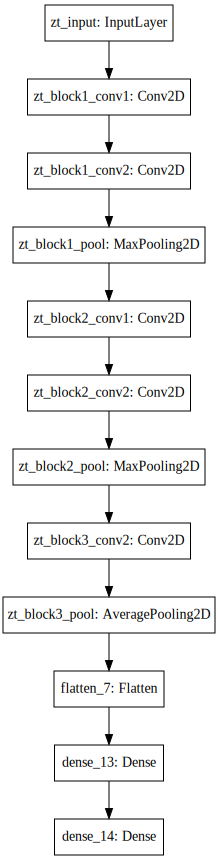

In [77]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(vgg_sep_model).create(prog='dot', format='svg'))

----

In [15]:
X_train.shape

(1480, 75, 16, 15, 18)

In [29]:
XT_train = np.sum(X_train, axis=(3, 4))
YT_train = np.sum(X_train, axis =(2, 4))
ZT_train = np.sum(X_train, axis=(2, 3))

XT_test = np.sum(X_test, axis=(3, 4))
YT_test = np.sum(X_test, axis =(2, 4))
ZT_test = np.sum(X_test, axis=(2, 3))


In [25]:
ZT_train.shape, XT_train.shape, YT_train.shape

((1480, 75, 18), (1480, 75, 16), (1480, 75, 15))

In [30]:
ZT_train = ZT_train[:, np.newaxis, ...]
XT_train = XT_train[:, np.newaxis, ...]
YT_train = YT_train[:, np.newaxis, ...]

ZT_test = ZT_test[:, np.newaxis, ...]
XT_test = XT_test[:, np.newaxis, ...]
YT_test = YT_test[:, np.newaxis, ...]

In [31]:
ZT_train.shape, XT_train.shape, YT_train.shape

((1480, 1, 75, 18), (1480, 1, 75, 16), (1480, 1, 75, 15))

In [41]:
fargs = {'num_classes': 2, 'optimizer': Adadelta()}
vgg_sep_model = vgg_like_zt(**fargs)

fitargs = {'batch_size': 64, 'epochs': 30, 'verbose': 1}
history_vgg_like_zt = vgg_sep_model.fit([ZT_train], to_categorical(y_train), **fitargs)

Epoch 1/30
1480/1480 [==============================] - 4s - loss: 0.6562 - acc: 0.6236     
Epoch 2/30
1480/1480 [==============================] - 4s - loss: 0.5169 - acc: 0.7412     
Epoch 3/30
1480/1480 [==============================] - 4s - loss: 0.4628 - acc: 0.8000     
Epoch 4/30
1480/1480 [==============================] - 4s - loss: 0.3434 - acc: 0.8412     
Epoch 5/30
1480/1480 [==============================] - 4s - loss: 0.3543 - acc: 0.8486     
Epoch 6/30
1480/1480 [==============================] - 4s - loss: 0.2765 - acc: 0.8784     
Epoch 7/30
1480/1480 [==============================] - 4s - loss: 0.2348 - acc: 0.8959     
Epoch 8/30
1480/1480 [==============================] - 4s - loss: 0.2085 - acc: 0.9054     
Epoch 9/30
1480/1480 [==============================] - 4s - loss: 0.1789 - acc: 0.9203     
Epoch 10/30
1480/1480 [==============================] - 4s - loss: 0.1663 - acc: 0.9318     
Epoch 11/30
1480/1480 [==============================] - 4s - loss: 0

In [42]:
print("Use model to make prediction on test data")
predictions = vgg_sep_model.predict([ZT_test])
cls_predictions = np.argmax(predictions, axis=1)

from sklearn.metrics import accuracy_score
score = accuracy_score(y_test, cls_predictions)
print("Accuracy score: ", score)

Use model to make prediction on test data
('Accuracy score: ', 0.93530997304582209)


### VGG-like with linear regression

In [67]:
from keras.layers import Input
from keras.layers import concatenate, add
from keras.layers.convolutional import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers.core import Flatten, Dense

from keras.models import Model
from keras.losses import categorical_crossentropy
from keras.optimizers import Adadelta

def vgg_like_zt(num_classes, optimizer, include_dense=False):
    """VGG inspired Convolutional Networks with multiple inputs
    
    Parameters
    ----------
    num_classes : int
        Number of classes to predict
            
    optimizer : keras.optimizers.Optimizer
        Instance of Keras optimizer to attach to the resulting network
        
    include_dense : bool (default False)
        Flag indicating wether to include a Dense Layer at the top 
        of each separate vgg-like sub-network.
    """
    
    def _conv_block(input_layer, include_dense=False):
        """VGG-inspired Convolutional Blocks"""
        
        prefix = input_layer.name.split('_')[0]

        # Block 1
        x = Conv2D(32, kernel_size=(3, 3), activation='relu', 
                   padding='same', name='{}_block1_conv1'.format(prefix))(input_layer)
        
        x = Conv2D(32, kernel_size=(3, 3), activation='relu', 
                   padding='same', name='{}_block1_conv2'.format(prefix))(x)
        
        x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), 
                         padding='same', name='{}_block1_pool'.format(prefix))(x)

        # Block 2
        x = Conv2D(64, kernel_size=(3, 3), activation='relu', 
                   padding='same', name='{}_block2_conv1'.format(prefix))(x)
        
        x = Conv2D(64, kernel_size=(3, 3), activation='relu', 
                   padding='same', name='{}_block2_conv2'.format(prefix))(x)
        
        x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), 
                         padding='same', name='{}_block2_pool'.format(prefix))(x)

        # Block 3
        x = Conv2D(128, kernel_size=(3, 3), activation='relu', 
                   padding='same', name='{}_block3_conv2'.format(prefix))(x)
        
        x = AveragePooling2D(pool_size=(2, 2), strides=(2, 2), 
                             padding='same', name='{}_block3_pool'.format(prefix))(x)
        x = Flatten()(x)
        return x

   
    ZT_SHAPE = (1, 75, 18)
    
    zt_layer = Input(shape=ZT_SHAPE, name='zt_input')
    
    zt_branch = _conv_block(zt_layer, include_dense)
    
    x = Dense(256,activation='relu')(zt_branch)
    predictions = Dense(1)(x)

    model = Model(inputs=[zt_layer], outputs=predictions, name='vgglike')
    model.compile(loss='mse', optimizer='adam')
    return model

In [15]:
X_train.shape


(2052, 75, 16, 15, 18)

In [16]:
ZT_train = np.sum(X_train, axis=(2, 3))

ZT_test = np.sum(X_test, axis=(2, 3))

In [17]:
ZT_train.shape

(2052, 75, 18)

In [18]:
ZT_train = ZT_train[:, np.newaxis, ...]
ZT_test = ZT_test[:, np.newaxis, ...]

In [19]:
ZT_train.shape, ZT_test.shape

((2052, 1, 75, 18), (513, 1, 75, 18))

In [71]:
fargs = {'num_classes': "", 'optimizer': Adadelta()}
vgg_sep_model = vgg_like_zt(**fargs)

fitargs = {'batch_size': 16, 'epochs': 20, 'verbose': 1, 'callbacks': [early_stop]}
history_vgg_like_zt_lr = vgg_sep_model.fit([ZT_train], y_train, **fitargs)

Epoch 1/20
2052/2052 [==============================] - 6s - loss: 0.1744     
Epoch 2/20
2052/2052 [==============================] - 6s - loss: 0.0846     
Epoch 3/20
2052/2052 [==============================] - 6s - loss: 0.0716     
Epoch 4/20
2052/2052 [==============================] - 6s - loss: 0.0577     
Epoch 5/20
2052/2052 [==============================] - 6s - loss: 0.0521     
Epoch 6/20
2052/2052 [==============================] - 6s - loss: 0.0484     
Epoch 7/20
2052/2052 [==============================] - 6s - loss: 0.0409     
Epoch 8/20
2052/2052 [==============================] - 6s - loss: 0.0364     
Epoch 9/20
2052/2052 [==============================] - 6s - loss: 0.0331     
Epoch 10/20
2052/2052 [==============================] - 6s - loss: 0.0270     
Epoch 11/20
2052/2052 [==============================] - 6s - loss: 0.0195     
Epoch 12/20
2052/2052 [==============================] - 6s - loss: 0.0180     
Epoch 13/20
2052/2052 [==========================

In [72]:
print("Use model to make prediction on test data")
predictions = vgg_sep_model.predict([ZT_test])
#cls_predictions = np.argmax(predictions, axis=1)


Use model to make prediction on test data


In [44]:
predictions

array([[  7.21691668e-01],
       [  3.04925263e-01],
       [ -2.89375365e-01],
       [  7.46879458e-01],
       [  7.00409114e-01],
       [ -1.14623427e-01],
       [  4.55944121e-01],
       [  2.27400526e-01],
       [ -4.72323716e-01],
       [  9.83546853e-01],
       [ -5.73165834e-01],
       [  3.41261446e-01],
       [  9.12612975e-01],
       [  4.74913538e-01],
       [  8.79318714e-01],
       [ -1.08667314e+00],
       [  6.56139292e-03],
       [ -1.57588750e-01],
       [ -1.80289447e-01],
       [ -1.18713550e-01],
       [  8.60799849e-01],
       [  9.45341885e-01],
       [ -6.16179407e-01],
       [  5.96055925e-01],
       [ -1.63305849e-01],
       [ -5.76038241e-01],
       [ -7.61951149e-01],
       [ -5.81353843e-01],
       [ -4.37501609e-01],
       [  4.01372135e-01],
       [  1.04360409e-01],
       [  2.26442739e-01],
       [  9.99102354e-01],
       [ -2.49437466e-01],
       [  2.19244465e-01],
       [ -5.07919133e-01],
       [  4.69307959e-01],
 

In [73]:
from sklearn.metrics import mean_squared_error

In [74]:
mean_squared_error(y_test, predictions)

0.080566082071483636

In [99]:
import root_numpy as rnp

In [83]:
numufile = "utilities/km3_v4_numucc_1_B.evt.aa.root"
nuefile = "utilities/km3_v4_nuecc_1.evt.JTE.aa.root"

In [84]:
E_numu = rnp.root2array(numufile, treename='E', branches='Evt.mc_trks.E')
type_numu = rnp.root2array(numufile, treename='E', branches = 'Evt.mc_trks.type')
E_nue = rnp.root2array(nuefile, treename='E', branches='Evt.mc_trks.E')
type_nue = rnp.root2array(nuefile, treename='E', branches = 'Evt.mc_trks.type')


E_numu_ = np.asarray([E_numu[evt][type_numu[evt]==5][0]for evt in range(E_numu.shape[0])])

E_nue_ = np.asarray([E_nue[evt][type_nue[evt]==3][0]for evt in range(E_nue.shape[0])])

In [100]:
E_numu_.shape

(1541,)

In [107]:
numu_ids = np.load("numu_evt_sel_5_doms.npz")
nue_ids = np.load("nue_evt_sel_5_doms.npz")

In [108]:
numu_map = numu_ids["id"]
nue_map = nue_ids["id"]

In [111]:
E_numu_sel5 = E_numu_[numu_map]
E_nue_sel5 = E_nue_[nue_map]

In [113]:
ZT_test.shape

(513, 1, 75, 18)

In [114]:
Energies = np.hstack((E_numu_sel5, E_nue_sel5))

In [115]:
E_train, E_test = Energies[indx_train], Energies[indx_test]

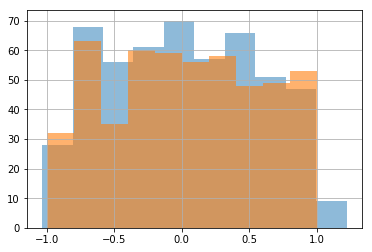

In [141]:
%matplotlib inline
plt.hist(predictions, alpha=0.5)
plt.hist(y_test, alpha=0.6)
plt.grid()
plt.show()